Wrapping the 2014 dataset data with `xarray`.

In [1]:
%matplotlib inline
%pylab inline
import collections, itertools, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
Recording = collections.namedtuple('Recording',['fn','df']) # filename and dataframe 
def load_data(dirpath):
    dfs = []
    for root, _, filenames in os.walk(dirpath):
        for filename in filenames:
            filepath = os.path.join(root,filename)
            nxt = pd.read_csv(filepath,index_col=0,compression='gzip')
            dfs.append(Recording(filename,nxt))
    return dfs

In [3]:
# load all files from data_clean directory into a list of DataFrames
data = load_data('../data_final')

In [4]:
coords_2014 = np.array([
    ['3', '15', '27', '39', '51', '63', '75', '87', '99', '111', '123'],
    ['4', '16', '28', '40', '52', '64', '76', '88', '100', '112', '124'],
    ['5', '17', '29', '41', '53', '65', '77', '89', '101', '113', '125'],
    ['6', '18', '30', '42', '54', '66', '78', '90', '102', '114', '126'],
    ['7', '19', '31', '43', '55', '67', '79', '91', '103', '115', '127'],
    ['8', '20', '32', '44', '56', '68', '80', '92', '104', '116', '128'],
    ['9', '21', '33', '45', '57', '69', '81', '93', '105', '117', '129'],
    ['10', '22', '34', '46', '58', '70', '82', '94', '106', '118', '130'],
    ['11', '23', '35', '47', '59', '71', '83', '95', '107', '119', '131'],
    ['12', '24', '36', '48', '60', '72', '84', '96', '108', '120', '132'],
    ['13', '25', '37', '49', '61', '73', '85', '97', '109', '121', '133'],
    ['14', '26', '38', '50', '62', '74', '86', '98', '110', '122', '134']
])
# rats with trial 097 (missing) and 122 (wrong length) removed, and rats 108 and 116 removed (garbage), and session 11 (rotated)
coords_2014 = np.array([
    ['4', '16', '28', '40', '52', '64', '76', '88', '100', '112'],
    ['5', '17', '29', '41', '53', '65', '77', '89', '101', '113'],
    ['6', '18', '30', '42', '54', '66', '78', '90', '102', '114'],
    ['7', '19', '31', '43', '55', '67', '79', '91', '103', '115'],
    ['8', '20', '32', '44', '56', '68', '80', '92', '104', '116'],
    ['9', '21', '33', '45', '57', '69', '81', '93', '105', '117'],
    ['10', '22', '34', '46', '58', '70', '82', '94', '106', '118'],
    ['12', '24', '36', '48', '60', '72', '84', '96', '108', '120']
])

In [5]:
data_2014 = [rec for rec in data if '2014' in rec.fn]
rats = ['109', '110', '111', '112', '113', '114', '115', '117'] #  '118', '119' removed
sessions = [f'injection{i+1}' for i in range(coords_2014.shape[1])]
times = pd.to_timedelta([t*40 for t in range(45001)],unit='ms')

In [6]:
def get_rec(session):
    return [rec for rec in data_2014 if rec.fn.split('_')[1].split('.')[0].lstrip('0')==str(session)][0]

In [7]:
x_data = np.array([[get_rec(session).df['X center (cm)'] for session in rat] for rat in coords_2014])
y_data = np.array([[get_rec(session).df['Y center (cm)'] for session in rat] for rat in coords_2014])
area_data = np.array([[get_rec(session).df['Area (cm²)'] for session in rat] for rat in coords_2014])
areachange_data = np.array([[get_rec(session).df['Areachange (cm²)'] for session in rat] for rat in coords_2014])
elongation_data = np.array([[get_rec(session).df['Elongation'] for session in rat] for rat in coords_2014])
direction_data = np.array([[get_rec(session).df['Direction (deg)'] for session in rat] for rat in coords_2014])
treatment_data = ['s' if int(rat)%2==0 else 'q' for rat in rats]
time_offset_data = np.array([[get_rec(session).df['Trial time (s)'][1] for session in rat] for rat in coords_2014])

In [8]:
## rotate position 180% of session 11, all rats except 109
#x_data[1:,10] = -x_data[1:,10]
#y_data[1:,10] = -y_data[1:,10]
## also subtract 180% from direction??

In [9]:
x = xr.DataArray(x_data, dims=['rat','session','time'], coords=[rats,sessions,times])
y = xr.DataArray(y_data, dims=['rat','session','time'], coords=[rats,sessions,times])
area = xr.DataArray(area_data, dims=['rat','session','time'], coords=[rats,sessions,times])
areachange = xr.DataArray(areachange_data, dims=['rat','session','time'], coords=[rats,sessions,times])
elongation = xr.DataArray(elongation_data, dims=['rat','session','time'], coords=[rats,sessions,times])
direction = xr.DataArray(direction_data, dims=['rat','session','time'], coords=[rats,sessions,times])
treatment = xr.DataArray(treatment_data, dims=['rat'], coords=[rats])
trial = xr.DataArray(coords_2014, dims=['rat','session'], coords=[rats,sessions])
time_offset = xr.DataArray(time_offset_data, dims=['rat','session'], coords=[rats,sessions])

In [10]:
data_vars = {'x': x, 'y': y, 'area': area, 'areachange': areachange, 'elongation': elongation, 'direction': direction, 'time_offset': time_offset}
coords = {'treatment': treatment, 'trial': trial}


attrs = {'dataset': '2014',
         'objects': np.array([(46.5, -42.5),(4.5, 44),(-69, -69),(-66.5, 73.5)]),
         'boundary': np.array([(-61.5,78),(-30,80.125),(0,80.75),(30,80.5),
                      (60,78.5),(81.5,76),(84.75,44),(84.75,10.5),
                      (82.5,-28.75),(76,-74),(43.75,-77.25),
                      (7.75,-77.25),(-27.25,-75.25),(-62.75,-70.25),
                      (-70.25,-62.25),(-73.75,-30),(-74.5,0.25),
                      (-73.5,38.25),(-69.75,68)])
        }

ds = xr.Dataset(data_vars, coords, attrs)

# set treatment order
treatment_order = ['s','q']
treatment_index = sorted(ds.rat.values,key=lambda r: (treatment_order.index(ds.treatment.sel(rat=r)),r))
ds = ds.reindex(rat=treatment_index)

In [4]:
import xarray as xr
xr.open_dataset('../xarray/2014.nc', engine='h5netcdf')

<xarray.Dataset>
Dimensions:      (rat: 8, session: 10, time: 45001)
Coordinates:
  * rat          (rat) object '110' '112' '114' '109' '111' '113' '115' '117'
  * session      (session) object 'injection1' 'injection2' 'injection3' ...
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    (rat) object 's' 's' 's' 'q' 'q' 'q' 'q' 'q'
    trial        (rat, session) object '5' '17' '29' '41' '53' '65' '77' ...
Data variables:
    area         (rat, session, time) float64 58.74 58.31 51.87 51.18 51.18 ...
    areachange   (rat, session, time) float64 14.86 13.48 12.28 11.85 12.71 ...
    direction    (rat, session, time) float64 147.6 137.3 135.0 129.3 130.0 ...
    elongation   (rat, session, time) float64 0.7867 0.7429 0.7395 0.7292 ...
    time_offset  (rat, session) float64 8.04 5.04 8.52 7.2 6.6 9.12 8.76 ...
    x            (rat, session, time) float64 -3.408 -3.288 -3.142 -2.898 ...
    y            (rat, session, time) float64 2.523 2.725 2.976 3.

In [23]:
encoding = {var:{'zlib': True} for var in itertools.chain(ds.coords,ds.data_vars)}
ds.to_netcdf('../xarray/2014.nc', encoding=encoding, engine='h5netcdf')

In [12]:
#ds = xr.open_dataset('../xarray/2014f.nc',engine='h5netcdf')

In [13]:
#ds = xr.Dataset({},{},{'test':[[1,2],[3,4]]})
#ds.to_netcdf('test.nc',engine='h5netcdf')
#xr.open_dataset('test.nc',engine='h5netcdf')

In [14]:
# Example usage
import datetime

In [15]:
# all sessions from week 1 for rats with treatment qns/saline
ds.sel(rat=ds.treatment=='q', session='injection1')

<xarray.Dataset>
Dimensions:      (rat: 5, time: 45001)
Coordinates:
  * rat          (rat) <U3 '109' '111' '113' '115' '117'
    session      <U11 'injection1'
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    (rat) <U1 'q' 'q' 'q' 'q' 'q'
    trial        (rat) <U3 '4' '6' '8' '10' '12'
Data variables:
    x            (rat, time) float64 7.499 7.486 7.506 7.475 7.393 7.363 ...
    y            (rat, time) float64 16.64 16.47 16.19 16.05 16.04 15.98 ...
    area         (rat, time) float64 86.9 86.73 87.33 86.65 84.33 82.78 85.1 ...
    areachange   (rat, time) float64 3.95 3.607 7.643 1.717 4.551 2.404 ...
    elongation   (rat, time) float64 0.68 0.693 0.6995 0.6898 0.6873 0.7001 ...
    direction    (rat, time) float64 -44.97 -49.37 -40.67 -42.84 -52.12 ...
    time_offset  (rat) float64 5.68 6.8 5.04 5.04 8.16
Attributes:
    dataset: 2014
    objects: [[ 46.5 -42.5]
 [  4.5  44. ]
 [-69.  -69. ]
 [-66.5  73.5]]
    boundary: [[-61.5    78.   ]

In [16]:
# select rat with index 0
ds.isel(rat=0)

<xarray.Dataset>
Dimensions:      (session: 10, time: 45001)
Coordinates:
    rat          <U3 '110'
  * session      (session) <U11 'injection1' 'injection2' 'injection3' ...
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    <U1 's'
    trial        (session) <U3 '5' '17' '29' '41' '53' '65' '77' '89' '101' ...
Data variables:
    x            (session, time) float64 -3.408 -3.288 -3.142 -2.898 -2.615 ...
    y            (session, time) float64 2.523 2.725 2.976 3.263 3.57 3.846 ...
    area         (session, time) float64 58.74 58.31 51.87 51.18 51.18 48.43 ...
    areachange   (session, time) float64 14.86 13.48 12.28 11.85 12.71 10.13 ...
    elongation   (session, time) float64 0.7867 0.7429 0.7395 0.7292 0.7138 ...
    direction    (session, time) float64 147.6 137.3 135.0 129.3 130.0 129.9 ...
    time_offset  (session) float64 8.04 5.04 8.52 7.2 6.6 9.12 8.76 7.92 8.2 ...
Attributes:
    dataset: 2014
    objects: [[ 46.5 -42.5]
 [  4.5  44.

In [17]:
# select rats where x is ever greater than 104
ds.sel(rat=(ds.x > 104).any(dim=('session','time')))

/usr/lib/python3.6/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.Dataset>
Dimensions:      (rat: 0, session: 10, time: 45001)
Coordinates:
  * rat          (rat) <U3 
  * session      (session) <U11 'injection1' 'injection2' 'injection3' ...
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    (rat) <U1 
    trial        (rat, session) <U3 
Data variables:
    x            (rat, session, time) float64 
    y            (rat, session, time) float64 
    area         (rat, session, time) float64 
    areachange   (rat, session, time) float64 
    elongation   (rat, session, time) float64 
    direction    (rat, session, time) float64 
    time_offset  (rat, session) float64 
Attributes:
    dataset: 2014
    objects: [[ 46.5 -42.5]
 [  4.5  44. ]
 [-69.  -69. ]
 [-66.5  73.5]]
    boundary: [[-61.5    78.   ]
 [-30.     80.125]
 [  0.     80.75 ]
 [ 30.     80.5  ]
 [ 60.     78.5  ]
 [ 81.5    76.   ]
 [ 84.75   44.   ]
 [ 84.75   10.5  ]
 [ 82.5   -28.75 ]
 [ 76.    -74.   ]
 [ 43.75  -77.25 ]
 [  7.75  -77.2

In [18]:
# select all datapoints between 1 and 2 minutes
ds.sel(time=slice(datetime.timedelta(minutes=1), datetime.timedelta(minutes=2)))

<xarray.Dataset>
Dimensions:      (rat: 8, session: 10, time: 1501)
Coordinates:
  * rat          (rat) <U3 '110' '112' '114' '109' '111' '113' '115' '117'
  * session      (session) <U11 'injection1' 'injection2' 'injection3' ...
  * time         (time) timedelta64[ns] 00:01:00 00:01:00.040000 ...
    treatment    (rat) <U1 's' 's' 's' 'q' 'q' 'q' 'q' 'q'
    trial        (rat, session) <U3 '5' '17' '29' '41' '53' '65' '77' '89' ...
Data variables:
    x            (rat, session, time) float64 47.41 46.93 46.35 45.69 45.15 ...
    y            (rat, session, time) float64 -34.76 -34.82 -34.63 -34.42 ...
    area         (rat, session, time) float64 77.54 80.12 73.42 67.84 70.16 ...
    areachange   (rat, session, time) float64 22.84 17.17 16.49 12.62 8.501 ...
    elongation   (rat, session, time) float64 0.6653 0.5069 0.6479 0.7382 ...
    direction    (rat, session, time) float64 23.15 31.19 33.12 -23.43 ...
    time_offset  (rat, session) float64 8.04 5.04 8.52 7.2 6.6 9.12 8.76 ..

In [19]:
# select all datapoints within 10 cm of position (0,0) (manhattan distance)
d = 10
x1,y1,x2,y2 = -d,-d,d,d
mask = (x1<ds.x) & (ds.x<x2) & (y1<ds.y) & (ds.y<y2)
ds.sel(time=mask.any(dim=('rat','session')))
# to get same size ds but with all other values set to nan:
# ds.where(mask)

/usr/lib/python3.6/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/usr/lib/python3.6/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


<xarray.Dataset>
Dimensions:      (rat: 8, session: 10, time: 12134)
Coordinates:
  * rat          (rat) <U3 '110' '112' '114' '109' '111' '113' '115' '117'
  * session      (session) <U11 'injection1' 'injection2' 'injection3' ...
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    (rat) <U1 's' 's' 's' 'q' 'q' 'q' 'q' 'q'
    trial        (rat, session) <U3 '5' '17' '29' '41' '53' '65' '77' '89' ...
Data variables:
    x            (rat, session, time) float64 -3.408 -3.288 -3.142 -2.898 ...
    y            (rat, session, time) float64 2.523 2.725 2.976 3.263 3.57 ...
    area         (rat, session, time) float64 58.74 58.31 51.87 51.18 51.18 ...
    areachange   (rat, session, time) float64 14.86 13.48 12.28 11.85 12.71 ...
    elongation   (rat, session, time) float64 0.7867 0.7429 0.7395 0.7292 ...
    direction    (rat, session, time) float64 147.6 137.3 135.0 129.3 130.0 ...
    time_offset  (rat, session) float64 8.04 5.04 8.52 7.2 6.6 9.12 8.

In [20]:
# rolling window over direction of certain trial
trial = ds.isel(rat=0,session=0)
r = trial.direction.rolling(time=25,center=True).mean()
speed = np.sqrt(trial.x.diff('time')**2 + trial.y.diff('time')**2)/0.04
#speed[r.isnull()] = np.nan

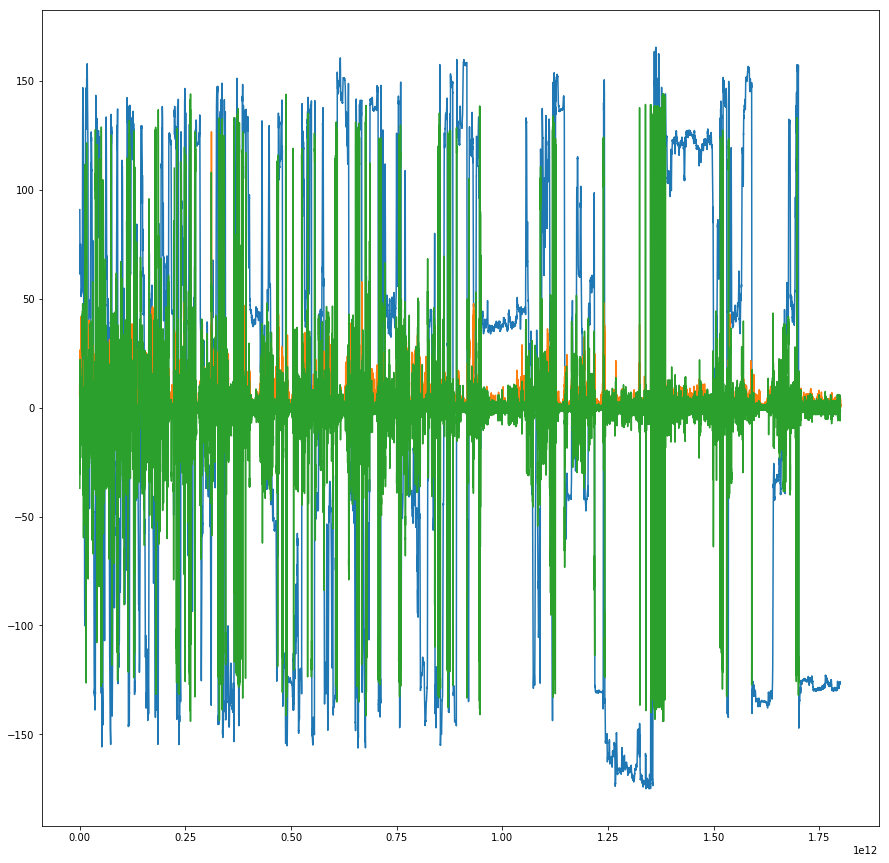

In [21]:
pylab.rcParams['figure.figsize'] = (15,15)
plt.plot(r.time,r.values)
plt.plot(speed.time,speed.values)
plt.plot(speed.time,pd.Series(r.values).diff()[1:]*10)

In [22]:
pd.Series(speed.values).corr(pd.Series(r.values).diff())

0.0019416917897207579